# Combine Catalogs
There's a LOT of EB catalogs in the literature, and some very good ones not yet published as well... In total we'll easily have a sample of many thousands of EBs to consider if we combine them

Here we'll combine catalogs to make a super-sample, and produce an easier to use file for the rest of the project.

Read in:
- ASAS-SN EBs
- Catalina EBs
- Kepler EBs (Villanova)
- CEV
- Erin Howard's TESS Sample (X-match to Gaia)

In [136]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.table import Table
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

from glob import glob

In [137]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
# matplotlib.rcParams.update({'font.family':'serif'})

# for the TESS Science Online 48hr sprint, we'll be using Cyberpunk for the graphics!
# https://github.com/dhaitz/mplcyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

## Read in every catalog

some need cleaning up, apply (roughly) uniform quality cuts where possible

In [3]:
# KEPLER

# already x-matched the Villanova EBs to Gaia DR2 & the Bailer-Jones catalogs
file = '../data/1543957677477A.csv'
df = pd.read_csv(file)

# df.columns
ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.02) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.02) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.02) & 
              (df['angDist'] < 0.5) & (df['angDist.1'] < 0.5))[0]

print(df.shape, ok.shape)

(7160, 75) (2346,)


In [4]:
# CATALINA

# i can't recall which catalog this came from originally, but it has been xmatched to Gaia DR2 & BailerJones
file = '../data/1540942562357A.csv'
df2 = pd.read_csv(file)

# df2.columns
ok2 = np.where(np.isfinite(df2['parallax']) & # this is basically the same as the TGAS file...
               (df2['parallax_error']/df2['parallax'] < 0.1) &
               (df2['ModFlag'] == 1) & 
               (df2['ResFlag'] == 1) &
               np.isfinite(df2['bp_rp']) & 
               (df2['phot_bp_mean_flux_error']/df2['phot_bp_mean_flux'] < 0.02) & 
               (df2['phot_rp_mean_flux_error']/df2['phot_rp_mean_flux'] < 0.02) & 
               (df2['phot_g_mean_flux_error']/df2['phot_g_mean_flux'] < 0.02) & 
               (df2['angDist'] < 0.5) &
               np.isfinite(df2['Per']))[0]

print(df2.shape, ok2.shape)

(59096, 57) (8863,)


In [184]:
# #ASAS-SN
# asas = pd.read_csv('../data/asassn-catalog.csv')
# asas.columns

# okA = np.where((asas['Mean VMag'] < 16) & 
#                (asas['Jmag'] - asas['Kmag'] > -0.5) &
#                (asas['Jmag'] - asas['Kmag'] < 2) &
#                (asas['Classification Probability'] > 0.9) & 
#                (asas['Type'] == 'EA') | (asas['Type'] == 'EB') | (asas['Type'] == 'EW'))[0]

# AokA = np.where((asas['Parallax Error'][okA]/asas['Parallax'][okA] < 0.1) &
#                 np.isfinite(asas['Jmag'][okA]) & 
#                 np.isfinite(asas['Kmag'][okA]) & 
#                 (asas['Jmag'][okA] - asas['Kmag'][okA] > -0.5) &
#                 (asas['Jmag'][okA] - asas['Kmag'][okA] < 2) &
#                 (asas['Parallax'][okA] > 0) &
#                 np.isfinite(asas['Parallax'][okA]))[0]
# print(asas.shape, okA.shape, AokA.shape)

In [106]:
#ASAS-SN
asassn = pd.read_csv('../data/2020-09-08-17_38_28.csv')
asassn.columns


Index(['ID', 'ASASSN_Name', 'Other Names', 'RAJ2000', 'DEJ2000', 'I', 'b',
       'Mean Vmag', 'Amplitude', 'Period', 'Type', 'Class_Probability',
       'LKSL Statistic', 'RFR_score', 'EpochHJD', 'GDR2_ID', 'Gmag', 'e_Gmag',
       'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'BP-RP', 'parallax',
       'parallax_error', 'parallax_over_error', 'PMRA', 'e_PMRA', 'PMDEC',
       'e_PMDEC', 'V_t', 'dist', 'ALLWISE_ID', 'Jmag', 'e_Jmag', 'Hmag',
       'e_Hmag', 'Kmag', 'e_Kmag', 'W1mag', 'e_W1mag', 'W2mag', 'e_W2mag',
       'W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'J-K', 'W1-W2', 'W3-W4',
       'APASS_DR9ID', 'APASS_Vmag', 'e_APASS_Vmag', 'APASS_Bmag',
       'e_APASS_Bmag', 'APASS_gpmag', 'e_APASS_gpmag', 'APASS_rpmag',
       'e_APASS_rpmag', 'APASS_ipmag', 'e_APASS_ipmag', 'B-V', 'E(B-V)',
       'Reference', 'Periodic', 'ASASSN_Discovery', 'URL'],
      dtype='object')

In [166]:
# drop W Uma's for now?
EBs = np.where(((asassn['Type'] == 'EA') | (asassn['Type'] == 'EB')) & # (asassn['Type'] == 'EW') | 
               (asassn['Class_Probability'] > 0.99) & 
               (asassn['parallax_over_error'] > 10) & 
               (asassn['parallax'] > 0) & 
               np.isfinite(asassn['parallax']) &
               (asassn['e_Gmag'] < 0.01)
              )[0]

print(asassn.shape, EBs.shape)

(666502, 67) (36103,)


0.220275

In [6]:
# Catalog of Eclipsing Variables
# http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/446/785
# xmatched to Gaia DR2

cev = pd.read_csv('../data/CEV-Gaia-2arcsec.csv')
# cev.columns

okC = np.where(np.isfinite(cev['parallax']) & 
               (cev['parallax_error']/cev['parallax'] < 0.1) &
               np.isfinite(cev['bp_rp']) & 
               (cev['phot_bp_mean_flux_error']/cev['phot_bp_mean_flux'] < 0.02) & 
               (cev['phot_rp_mean_flux_error']/cev['phot_rp_mean_flux'] < 0.02) & 
               (cev['phot_g_mean_flux_error']/cev['phot_g_mean_flux'] < 0.02) & 
               np.isfinite(cev['Per']))[0]

print(cev.shape, okC.shape)

(4334, 53) (1252,)


In [69]:
# add Erin's catalog, use TIC to join with Trevor's Gaia-xmatch
elh = pd.read_csv('../data/ehoward.txt')

# KIC-to-TIC conversion, if needed?
KICTIC = pd.read_csv('/Users/james/Dropbox/research_projects/kic2tic/KIC2TIC.csv')

# the TESS-Gaia xmatch from Trevor
gdir = '/Users/james/Dropbox/research_projects/TESS-Gaia/'
gfiles = glob(gdir+'*1arsec-result.csv')
gaia = pd.concat((pd.read_csv(f) for f in gfiles), ignore_index=True, sort=False)

EHow = pd.merge(elh, gaia, left_on='TIC', right_on='ticid', how='inner').drop_duplicates(subset=['TIC'])

Eok = np.where(np.isfinite(EHow['parallax']) & 
               (EHow['parallax_error']/EHow['parallax'] < 0.1) &
               np.isfinite(EHow['bp_rp']) & 
               (EHow['phot_bp_mean_flux_error']/EHow['phot_bp_mean_flux'] < 0.02) & 
               (EHow['phot_rp_mean_flux_error']/EHow['phot_rp_mean_flux'] < 0.02) & 
               (EHow['phot_g_mean_flux_error']/EHow['phot_g_mean_flux'] < 0.02)
              )[0]

print(EHow.shape, Eok.shape)

(464, 139) (418,)


In [54]:
#  Malkov 2020, http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J%2FMNRAS%2F491%2F5489%2Ftablea1
m20 = pd.read_csv('../data/1599574064401A.csv')

okM = np.where(np.isfinite(m20['parallax']) & 
               (m20['parallax_error']/cev['parallax'] < 0.1) &
               np.isfinite(m20['bp_rp']) & 
               (m20['phot_bp_mean_flux_error']/m20['phot_bp_mean_flux'] < 0.02) & 
               (m20['phot_rp_mean_flux_error']/m20['phot_rp_mean_flux'] < 0.02) & 
               (m20['phot_g_mean_flux_error']/m20['c_flux'] < 0.02) & 
               np.isfinite(m20['Per']))[0]

print(m20.shape, okM.shape)

(123, 63) (59,)


In [ ]:
# other catalogs?

## Combine

Make a single big Pandas dataframe

In [ ]:
# columns to grab:
# make the CMD: distance, bp_rp color, Gmag
# def want to save Periods - they available for all catalogs?
# prob want to save Gaia "source_id" so we can unique the list

In [178]:
save_cols = ['source_id', 'bp_rp', 'parallax', 'phot_g_mean_mag', 'Per']

# Kepler 
# df[save_cols].loc[ok]

# Catalina
# df2[save_cols].loc[ok2]

# Catalog of Eclipsing Variables
# cev[save_cols].loc[okC]

# Malkov'20
# m20[save_cols].loc[okM]

# ASAS-SN
asassn.rename(columns={'GDR2_ID':'source_id', 'BP-RP':'bp_rp','Gmag':'phot_g_mean_mag', 'Period':'Per'}, 
              inplace=True)
# asassn[save_cols].loc[EBs]

BigCat = pd.concat((df[save_cols].loc[ok], 
                    df2[save_cols].loc[ok2], 
                    cev[save_cols].loc[okC], 
                    m20[save_cols].loc[okM], 
                    asassn[save_cols].loc[EBs]), 
                   ignore_index=True, sort=False)


In [187]:
BigCat['source_id'].unique().size

46004

Text(0, 0.5, '$M_G$ (mag)')

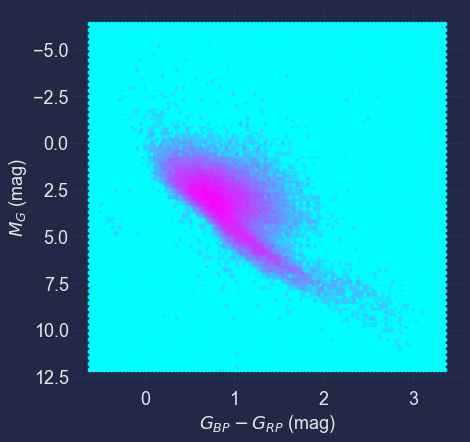

In [183]:
plt.figure(figsize=(7,7))
plt.hexbin(BigCat['bp_rp'], 
            BigCat['phot_g_mean_mag'] - 5. * np.log10(1000./BigCat['parallax']) + 5,
           norm=LogNorm(), cmap=plt.cm.cool)

plt.gca().invert_yaxis()

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

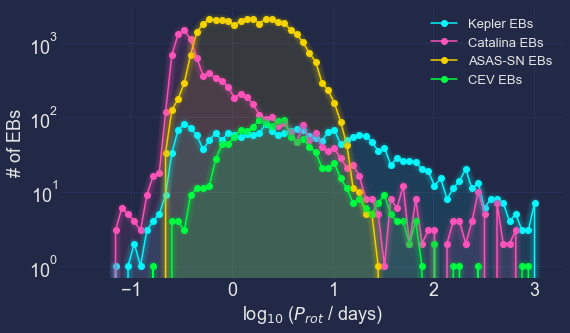

In [186]:
plt.figure(figsize=(9,5))
Hbins = np.linspace(-1.5, 3.1, num=75)

hist,be = np.histogram(np.log10(df['Per'][ok]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='Kepler EBs')

hist,be = np.histogram(np.log10(df2['Per'][ok2]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='Catalina EBs')

hist,be = np.histogram(np.log10(asassn['Per'][EBs].astype('float')), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='ASAS-SN EBs')

hist,be = np.histogram(np.log10(cev['Per'][okC]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='CEV EBs')

plt.xlabel('log$_{10}$ ($P_{rot}$ / days)')
plt.yscale('log')
plt.ylabel('# of EBs')
plt.legend(fontsize=13)

# alas, these don't work w/ histograms... yet!
mplcyberpunk.add_glow_effects()

# plt.savefig('.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [ ]:
plt.scatter(gaia[u'bp_rp'].values[Gok], 
            gaia[u'phot_g_mean_mag'].values[Gok] - 5. * np.log10(gaia[u'r_est'].values[Gok])  + 5, 
            alpha=0.7, s=2, cmap=cm)

